# CIDS: Conventional Intrusion Detection System
### Created: Dec 30, 2022


---


This notebook contains code for both training and evaluating a conventional (non-federated) autoencoder-based anomaly detector for the SynCAN dataset. This will serve as a stepping stone and baseline for the federated version.

This version of the IDS will only be trained on a single message ID, similar to INDRA. We can create a separate model for each ID in the dataset then AND their outputs during inference time in order to detect anomalies which only effect certain messages. This has the added benefit of simplifying the model to only use 1-4 signals instead of all 20 and avoids the problem of using unbalanced data.

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from psutil import virtual_memory
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(f'GPU: {gpu_info[599:619]}')
ram_gb = virtual_memory().total / 1e9
print(f'RAM: {ram_gb:.1f} GB')

GPU: 
RAM: 13.6 GB


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from keras import layers
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
signal_counts = [2, 3, 2, 1, 2, 2, 2, 1, 1, 4] # number of signals contained in each message ID

In [ ]:
ID = 5
MSG_ID = 'id'+str(ID)      # each message contains 1-4 signals that are associated with the specified message ID
NUM_SIGNALS = signal_counts[ID-1]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TIME_STEPS = 100
SEQ_STRIDE = TIME_STEPS // 2 # must be <= TIME_STEPS
EPOCHS = 3
BATCH_SIZE = 64
LEARNING_RATE = 0.001
DROP_OUT = True
LOSS_FUNCTION = 'mse'
METRIC = 'binary_crossentropy'
PATIENCE = 1
LATENT_DIM = 32 * NUM_SIGNALS
DIRECTORY = "/content/drive/MyDrive/Colab Notebooks/models/cids/"
FILEPATH = DIRECTORY+MSG_ID+"_model_"+str(TIME_STEPS)+".h5"
EVAL_SET = 'continuous'
# PNGFILEPATH = DIRECTORY+MSG_ID+"_model.png"


# Preparing the SynCAN Dataset

In [ ]:
# Download SynCAN dataset from the ETAS github
!git clone https://github.com/etas/SynCAN.git &> /dev/null
!unzip ./SynCAN/\*.zip -d ./SynCAN/. &> /dev/null
!rm ./SynCAN/*.zip &> /dev/null

In [ ]:
def train_csv2df(dir_path): # imports training files into a dataframe
    data_frames = []
    csv_path = dir_path + '/train_1.csv'    # train 1 contains header
    df_temp = pd.read_csv(csv_path)
    data_frames.append(df_temp)
    for i in range(2, 5):
        csv_path = dir_path + '/train_' + str(i) + '.csv'
        df_temp = pd.read_csv(csv_path, header=None, names=['Label',  'Time', 'ID',
                                                            'Signal1', 'Signal2',  'Signal3', 'Signal4'])
        data_frames.append(df_temp)
    df = pd.concat(data_frames)
    return df

def prepare_train_df(): # convert csv, isolate message ID and remove unused columns
    df = train_csv2df('/content/SynCAN')
    print(f'{len(df):,} total messages (id1,id2,...,id10)')

    df = df[:][df.ID==MSG_ID] # use only messages with MSG_ID
    df = df.dropna(axis=1, how='all') # remove unused signal columns
    df.reset_index(drop=True, inplace=True)

    df_labels = df.iloc[:,0:1].astype(int) # dataframe of labels (removing Time and ID columns)
    df = df.iloc[:,3:] # dataframe of signal values
    df = df_labels.join(df)
    print(f'{len(df):,} messages used ({MSG_ID})\n')
    return df

In [ ]:
df = prepare_train_df()
df

29,669,726 total messages (id1,id2,...,id10)
4,139,820 messages used (id5)



,Label,Signal1,Signal2
0,0,0.000000,0.958686
1,0,0.000000,0.958686
2,0,0.000000,0.958686
3,0,0.000000,0.956420
4,0,0.000000,0.956420
...,...,...,...
4139815,0,0.329627,0.948088
4139816,0,0.334278,0.948088
4139817,0,0.338807,0.948088
4139818,0,0.342955,0.948461


In [ ]:
def visualize_data(df, length=1000, start=0):
    data = df.iloc[start:start+length].copy()
    colors = ['blue', 'orange', 'green', 'red']
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
    for i in range(df.shape[1]-1):
        key = 'Signal'+str(i+1)
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = list(range(length))
        ax = t_data.plot(
            ax = axes[i // 2, i % 2],
            color = c,
            title = MSG_ID.upper()+'_'+key,
            rot = 25,
        )
    plt.tight_layout()
    plt.show()

length = 1000
start = np.random.randint(len(df)-length)
print(f'Viewing messages {start} to {start+length}\n')
visualize_data(df, start=start, length=length)

In [ ]:
# derived from the keras timeseries_dataset_from_array function
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array
def timeseries_dataset(
    data,
    targets,
    sequence_length,
    data_is_target=False,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=1,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None):
  
  if start_index is None:
    start_index = 0
  if end_index is None:
    end_index = len(data)

  # Determine the lowest dtype to store start positions (to lower memory usage).
  num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1
  if targets is not None:
    num_seqs = min(num_seqs, len(targets))
  if num_seqs < 2147483647:
    index_dtype = 'int32'
  else:
    index_dtype = 'int64'

  # Generate start positions
  start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
  if shuffle:
    if seed is None:
      seed = np.random.randint(1e6)
    rng = np.random.RandomState(seed)
    rng.shuffle(start_positions)

  sequence_length = tf.cast(sequence_length, dtype=index_dtype)
  sampling_rate = tf.cast(sampling_rate, dtype=index_dtype)

  positions_ds = tf.data.Dataset.from_tensors(start_positions).repeat()

  # For each initial window position, generates indices of the window elements
  indices = tf.data.Dataset.zip(
      (tf.data.Dataset.range(len(start_positions)), positions_ds)).map(
          lambda i, positions: tf.range(  # pylint: disable=g-long-lambda
              positions[i],
              positions[i] + sequence_length * sampling_rate,
              sampling_rate),
          num_parallel_calls=tf.data.AUTOTUNE)

  dataset = sequences_from_indices(data, indices, start_index, end_index)
  if targets is not None:
    indices = tf.data.Dataset.zip(
        (tf.data.Dataset.range(len(start_positions)), positions_ds)).map(
            lambda i, positions: positions[i],
            num_parallel_calls=tf.data.AUTOTUNE)
    target_ds = sequences_from_indices(
        targets, indices, start_index, end_index)
    dataset = tf.data.Dataset.zip((dataset, target_ds))
  else:
    if data_is_target:
        dataset = tf.data.Dataset.zip((dataset, dataset))
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  if batch_size is not None:
    if shuffle:
      # Shuffle locally at each iteration
      dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
    dataset = dataset.batch(batch_size)
  else:
    if shuffle:
      dataset = dataset.shuffle(buffer_size=1024, seed=seed)
  return dataset

def sequences_from_indices(array, indices_ds, start_index, end_index):
  dataset = tf.data.Dataset.from_tensors(array[start_index : end_index])
  dataset = tf.data.Dataset.zip((dataset.repeat(), indices_ds)).map(
      lambda steps, inds: tf.gather(steps, inds),  # pylint: disable=unnecessary-lambda
      num_parallel_calls=tf.data.AUTOTUNE)
  return dataset


In [ ]:
# Define training, validation and testing datasets using the training dataset function
def SynCAN_train_ds(df):
    values = df.to_numpy()[:,1:]
    ds = timeseries_dataset(
        values,
        None,
        data_is_target = True,
        sequence_length = TIME_STEPS,
        sequence_stride = SEQ_STRIDE,
        # batch_size = BATCH_SIZE
    )
    return ds

data_length = len(df)
train_size = (int(data_length*TRAIN_SPLIT) // SEQ_STRIDE) * SEQ_STRIDE
val_size = (int(data_length*VAL_SPLIT) // SEQ_STRIDE) * SEQ_STRIDE
test_size = ((data_length - train_size - val_size) // SEQ_STRIDE) * SEQ_STRIDE

train_df = df.iloc[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df.iloc[-test_size:]

train_ds = SynCAN_train_ds(train_df)
val_ds = SynCAN_train_ds(val_df)
test_ds = SynCAN_train_ds(test_df)

datasets = {'train': train_ds, 'val': val_ds, 'test': test_ds}
for key, item in datasets.items():
    print(f"{key.upper()}: \t{item.__len__().numpy():,} subsequences of length {TIME_STEPS}")

TRAIN: 	66,236 subsequences of length 100
VAL: 	8,278 subsequences of length 100
TEST: 	8,279 subsequences of length 100


# Defining and Compiling a New Model

In [ ]:
def get_CIDS_model(time_steps, input_dim, latent_dim, drop_out=False):
    inputs = layers.Input(shape=(time_steps, input_dim)) # shape = (time_steps, data_dimension/num_features)
    # encoder
    x = layers.Dense(latent_dim*2, activation='tanh')(inputs)
    if drop_out: x = layers.Dropout(0.2)(x)
    enc_out, enc_hidden = layers.GRU(latent_dim, return_sequences=True, return_state=True, activation="tanh")(x)
    if drop_out:
        enc_out = layers.Dropout(0.2)(enc_out)
        enc_hidden = layers.Dropout(0.2)(enc_hidden)
    # decoder
    dec_out , dec_hidden = layers.GRU(latent_dim, return_sequences=True, return_state=True, activation="tanh")(enc_out)
    if drop_out:
        dec_out = layers.Dropout(0.2)(dec_out)
        dec_hidden = layers.Dropout(0.2)(dec_hidden)
    
    outputs = layers.Dense(input_dim, activation='tanh')(dec_out)
    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=PATIENCE,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=FILEPATH,
        monitor="val_loss",
        save_best_only=True,
    )
]

model = get_CIDS_model(TIME_STEPS, input_dim=df.shape[1]-1, latent_dim=LATENT_DIM, drop_out=DROP_OUT)

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=LOSS_FUNCTION,
    metrics=[METRIC])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 2)]          0         
                                                                 
 dense (Dense)               (None, 100, 128)          384       
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 gru (GRU)                   [(None, 100, 64),         37248     
                              (None, 64)]                        
                                                                 
 dropout_1 (Dropout)         (None, 100, 64)           0         
                                                                 
 gru_1 (GRU)                 [(None, 100, 64),         24960     
                              (None, 64)]                    

# Model Training and Validation

In [ ]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    use_multiprocessing=True,
                    workers=6,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    callbacks=callbacks_list)

66236/66236 [==============================] - 627s 9ms/step - loss: 8.0487e-04 - binary_crossentropy: 0.4409 - val_loss: 6.7461e-04 - val_binary_crossentropy: 0.4719


In [ ]:
if EPOCHS > 1:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
loss, metric = model.evaluate(val_ds, verbose=0)
print(f'Validation loss: {loss:.5}\nValidation {METRIC}: {metric:.5}')
print()

loss, metric = model.evaluate(test_ds, verbose=0)
print(f'Test loss: {loss:.5}\nTest {METRIC}: {metric:.5}')        # current best: 0.000229148383368738

Validation loss: 0.0006746146245859563
Validation binary_crossentropy: 0.4718779921531677
Test loss: 0.000790777790825814
Test binary_crossentropy: 0.4337236285209656


# Reconstructing Data and Selecting Thresholds

In [ ]:
def reconstruct(ds): # used for reconstructing signals with a saved model into a continuous dataframe
    saved_model = tf.keras.models.load_model(FILEPATH)
    reconstruction = saved_model.predict(ds, verbose=1, workers=-1, use_multiprocessing=True)
    if TIME_STEPS == SEQ_STRIDE:
        reconstruction = reconstruction.reshape(-1, reconstruction.shape[-1])
    else:
        # remove duplicate timesteps from predictions
        # first = reconstruction[0,:TIME_STEPS-SEQ_STRIDE]    # e.g. [0..10] out of [0..20]
        first = reconstruction[0]
        rest = reconstruction[1:,TIME_STEPS-SEQ_STRIDE:]    # e.g. [10..20],[20..30].. out of [10..30],[20..40]..
        rest = rest.reshape(-1, rest.shape[-1])             # e.g. [10....len(df)]
        reconstruction = np.concatenate((first, rest))      # e.g. [0....len(df)]
    columns = ['Signal'+str(i+1) for i in range(reconstruction.shape[-1])]
    return pd.DataFrame(reconstruction, columns=columns)

def get_thresholds(df, reconstruction): # used for detecting reconstructions that are significantly different from the orignal
    # returns a numpy array containing a threshold for each signal
    real_values = df.to_numpy()[:,1:]
    reconstructed_values = reconstruction.to_numpy()
    squared_error = np.square(real_values - reconstructed_values)
    thresholds = squared_error.mean(axis=0) + (2 * squared_error.std(axis=0))
    return thresholds, squared_error

def get_predictions(df, reconstruction): # used to label messages as normal or anomalous
    # accepts two dataframes of the same length containing the same number of signals
    # returns a numpy array of 1s and 0s similar to the labels in df
    real_values = df.to_numpy()[:,1:]
    reconstructed_values = reconstruction.to_numpy()
    squared_error = np.square(real_values - reconstructed_values)
     # if any signal is above respective threshold, prediction is 1 for that timestep
    predictions = 1*(squared_error > thresholds)
    return predictions

def find_ranges(predictions): # used for highlighting in plots
    # accepts a list/vector of 1s and 0s
    # returns a list of range tuples which contain a start and end index
    ranges = []
    i = 0
    while i < len(predictions):
        if predictions[i]:
            start = i
            while True:
                i += 1
                if i >= len(predictions):
                    break
                if not predictions[i]:
                    break
            end = i
            ranges.append((start, end))
        i += 1
    return ranges

def visualize_reconstructed_signal(in_df, out_df, length=None, start=0, predict=False, show_se=False):
    # accepts two dataframes of the same length with the same number of signals - keys must be Signal1, Signal2,...
    if length is None:
        start = 0
        length = len(in_df)
    data = in_df.iloc[start:start+length].copy()
    reconstructed_data = out_df.iloc[start:start+length].copy()
    num_signals = reconstructed_data.shape[1]
    labels = data['Label']
    nrows = 2 if num_signals > 3 else 1
    ncols = num_signals if num_signals < 4 else 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,nrows*4), dpi=80, facecolor="w", edgecolor="k")
    for i in range(num_signals):
        key = 'Signal'+str(i+1)
        t_data = data[key]
        t_data.index = list(range(length))
        t_reconstructed_data = reconstructed_data[key]
        t_reconstructed_data.index = list(range(length))
        ax = axes[i // 2, i % 2] if nrows>1 else axes[i]
        ax0 = t_data.plot(
            ax=ax,
            color="black",
            title=MSG_ID.upper()+'_'+key,
            rot=25,
        )
        ax1 = t_reconstructed_data.plot(
            ax=ax,
            color="red",
            rot=10,
        )
        if show_se: # plot squared error
            se = np.square(t_data - t_reconstructed_data)
            ax2 = ax0.twinx()
            ax2.plot(se, alpha=0.5)
            ax2.set_ylabel('squared error')
        ranges = find_ranges(labels.to_numpy())
        for start, end in ranges:
            ax0.axvspan(start, end, color='grey', alpha=0.3)
        if predict:
            predictions = get_predictions(data, reconstructed_data)
            ranges = find_ranges(predictions[:, i])
            print(ranges)
            for start, end in ranges:
                ax1.axvspan(start, end, color='red', alpha=0.3)
        ax1.legend(['Original Signal', 'Reconstructed Signal'], loc='upper left')
        ax2.legend(['Squared Error'], loc='upper right')
    plt.tight_layout()
    plt.show()

In [ ]:
test_reconstruction = reconstruct(test_ds)
if test_reconstruction.shape[0] == len(test_df):
    print('reconstruction successful')

8279/8279 [==============================] - 128s 15ms/step
reconstruction successful


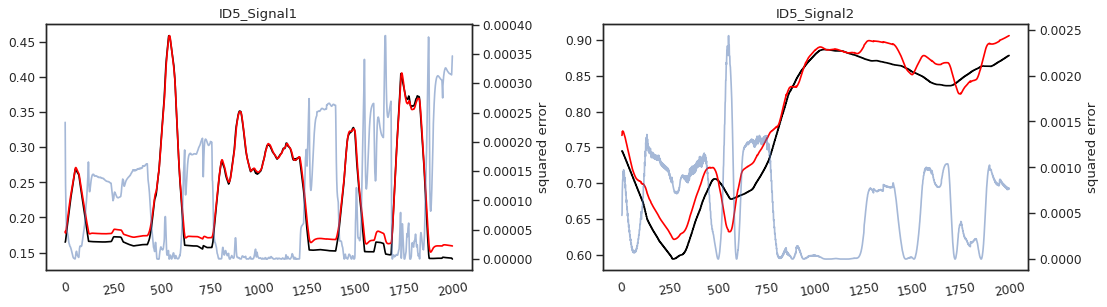

In [ ]:
visualize_reconstructed_signal(test_df, test_reconstruction, 2000, show_se=True)

In [ ]:
thresholds, squared_error = get_thresholds(test_df, test_reconstruction)
thresholds

array([0.00063975, 0.01125684])

In [ ]:
for signal in range(squared_error.shape[-1]): # Plot histograms of squared error values and mean + threshold lines
    se = squared_error[:,signal]
    plt.figure(figsize=(12,3))
    sns.set(font_scale = 1)
    sns.set_style("white")
    plt.xlim([0, 2*thresholds[signal]])
    sns.histplot(np.clip(se, 0, 2 * thresholds[signal]), bins=50, kde=True, color='grey')
    plt.axvline(x=np.mean(se), color='g', linestyle='--', linewidth=3)
    plt.text(np.mean(se), 250, "Mean", horizontalalignment='left', 
            size='small', color='black', weight='semibold')
    plt.axvline(x=thresholds[signal], color='b', linestyle='--', linewidth=3)
    plt.text(thresholds[signal], 250, "Threshold", horizontalalignment='left', 
            size='small', color='Blue', weight='semibold')
    plt.xlabel('Squared Error')
    plt.title('Signal '+str(signal+1))
    sns.despine()

# Intrusion Detection Evaluation

In [ ]:
def eval_csv2df(dir_path, test_file):  # imports evaluation (abnormal) data into dataframe
    data_frames = []
    csv_path = dir_path + '/test_' + test_file + '.csv'
    df = pd.read_csv(csv_path, header=None, skiprows=1, names=['Label',  'Time', 'ID',
                                                               'Signal1',  'Signal2',  'Signal3',  'Signal4'])
    return df

def prepare_eval_df(test_file='normal'):
    # convert csv, standardize features and trim to multiple of TIME_STEPS
    df = eval_csv2df('/content/SynCAN', test_file)
    print(f'{len(df):,} total messages (id1,id2,...,id10)')
    df = df[:][df.ID==MSG_ID] # use only messages with MSG_ID
    df = df.dropna(axis=1, how='all') # remove unused signal columns
    num_subsequences = len(df) // TIME_STEPS
    df = df.iloc[:(num_subsequences*TIME_STEPS)]
    df.reset_index(drop=True, inplace=True)
    df_labels = df.iloc[:,0:1].astype(int) # dataframe of labels (removing Time and ID columns)
    df = df.iloc[:,3:] # dataframe of signal values
    # df = (df - df.min()) / (df.max() - df.min())  # data seems to be already normalized
    print(f'{len(df):,} messages used ({MSG_ID})')
    num_anomalous = len(df_labels[df_labels['Label']==1])
    print(f'{num_anomalous:,} anomalous messages out of {len(df):,}\n')
    return df_labels.join(df)

def SynCAN_eval_ds(df):
    values = df.to_numpy()[:,1:]
    ds = timeseries_dataset(
        values,
        None,
        data_is_target = False,
        sequence_length = TIME_STEPS,
        sequence_stride = SEQ_STRIDE,
        batch_size = 1,
    )
    return ds

## Evaluation using Normal Data

In [ ]:
normal_df = prepare_eval_df()
normal_ds = SynCAN_eval_ds(normal_df)
# normal_df = normal_df.iloc[:-10]

normal_df.head()

2,150,052 total messages (id1,id2,...,id10)
299,900 messages used (id5)
0 anomalous messages out of 299,900



,Label,Signal1,Signal2
0,0,0.327077,0.931964
1,0,0.324893,0.931964
2,0,0.322131,0.931964
3,0,0.319376,0.932595
4,0,0.316747,0.932595


In [ ]:
# produce reconstructed signals
normal_reconstruction = reconstruct(normal_ds)
normal_reconstruction.shape

5997/5997 [==============================] - 88s 14ms/step


(299900, 2)

In [ ]:
predictions = get_predictions(normal_df, normal_reconstruction)
false_positive_rate = len(predictions[predictions==1])/len(predictions)
false_positive_rate

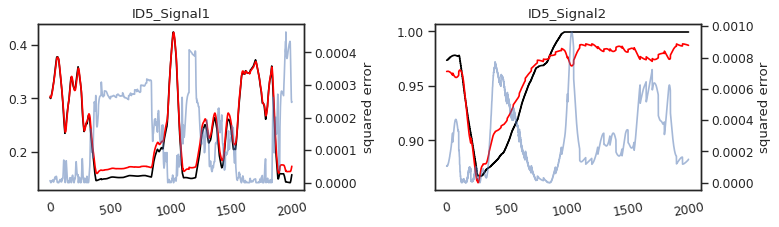

In [ ]:
visualize_reconstructed_signal(normal_df, normal_reconstruction, 2000, start=250, show_se=True)

## Evaluation using Anomalous Data

In [ ]:
eval_df = prepare_eval_df(EVAL_SET)
eval_ds = SynCAN_eval_ds(eval_df)

eval_df.head()

2,150,052 total messages (id1,id2,...,id10)
299,900 messages used (id5)
40,090 anomalous messages out of 299,900



,Label,Signal1,Signal2
0,0,0.166868,0.999369
1,0,0.167433,0.999369
2,0,0.167876,0.999369
3,0,0.168385,0.999369
4,0,0.169026,0.999369


In [ ]:
eval_reconstruction = reconstruct(eval_ds)

In [ ]:
# [0.00063975, 0.01125684]
thresholds = np.array([0.002, 0.0005])

[(135, 143), (150, 390), (531, 540), (565, 604), (994, 1050), (1057, 1069), (1097, 1100), (1118, 1386)]
[(935, 1000)]


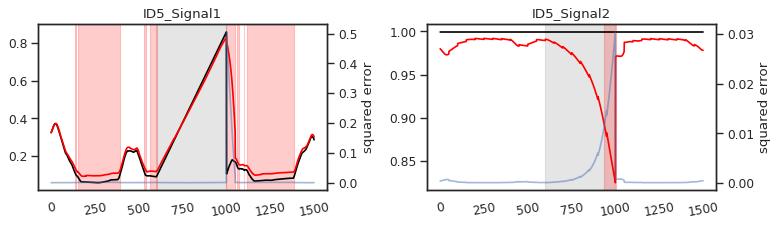

In [ ]:
visualize_reconstructed_signal(eval_df, eval_reconstruction, 1500, 2000, predict=True, show_se=True)

In [ ]:
real_labels = eval_df['Label'].to_numpy()
predictions = np.max(get_predictions(eval_df, eval_reconstruction), axis=1)
cm = confusion_matrix(real_labels, predictions)
cm
# True Neg, False Neg
# False Pos, True Pos

array([[245958,  13852],
       [ 38138,   1952]])

In [ ]:
b_accuracy = balanced_accuracy_score(real_labels, predictions)
print(f'Balanced Accuracy: {b_accuracy}')       # current best: 0.523

Balanced Accuracy: 0.49768728090521164
